# Premier League Outcomes Analysis (2015–2025)

This notebook computes and visualizes season-by-season Premier League match outcomes (home wins, draws, away wins) and an overall summary for the 10-season period. Figures are derived from the cleaned matches dataset.


In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 200)
PROCESSED = Path('../data/processed')
PL_FILE = PROCESSED / 'PL_matches_10years_cleaned.csv'

print(f"Loading: {PL_FILE}")
pl = pd.read_csv(PL_FILE, parse_dates=['Date'])
print(pl.shape)
print(sorted(pl['Season'].unique()))


Loading: ../data/processed/PL_matches_10years_cleaned.csv
(3800, 50)
['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']


In [3]:
# Compute per-season outcome counts and percentages
# FTR: 'H' (home win), 'D' (draw), 'A' (away win)

season_group = pl.groupby('Season')
counts = season_group['FTR'].value_counts().unstack(fill_value=0).rename(columns={'H':'Home Wins','D':'Draws','A':'Away Wins'})
counts['Total Matches'] = counts.sum(axis=1)

# Percentages (numeric)
pct = (counts[['Home Wins','Draws','Away Wins']].div(counts['Total Matches'], axis=0) * 100).round(0).astype(int)
season_table = pd.concat([pct, counts['Total Matches']], axis=1)

# Reorder by season
season_table = season_table.reset_index()

# Add overall row
overall_counts = pl['FTR'].value_counts().reindex(['H','D','A']).fillna(0).astype(int)
overall_total = int(len(pl))
overall_pct = (overall_counts / overall_total * 100).round(0).astype(int)

overall_row = {
    'Season': 'Overall',
    'Home Wins': f"{overall_pct['H']}%",
    'Draws': f"{overall_pct['D']}%",
    'Away Wins': f"{overall_pct['A']}%",
    'Total Matches': overall_total
}

season_table_formatted = season_table.copy()
for col in ['Home Wins','Draws','Away Wins']:
    season_table_formatted[col] = season_table_formatted[col].astype(str) + '%'

season_table_formatted = pd.concat([season_table_formatted, pd.DataFrame([overall_row])], ignore_index=True)
season_table_formatted


,Season,Home Wins,Draws,Away Wins,Total Matches
0,2015-2016,41%,28%,31%,380
1,2016-2017,49%,22%,29%,380
2,2017-2018,46%,26%,28%,380
3,2018-2019,48%,19%,34%,380
4,2019-2020,45%,24%,31%,380
5,2020-2021,38%,22%,40%,380
6,2021-2022,43%,23%,34%,380
7,2022-2023,48%,23%,29%,380
8,2023-2024,46%,22%,32%,380
9,2024-2025,41%,24%,35%,380


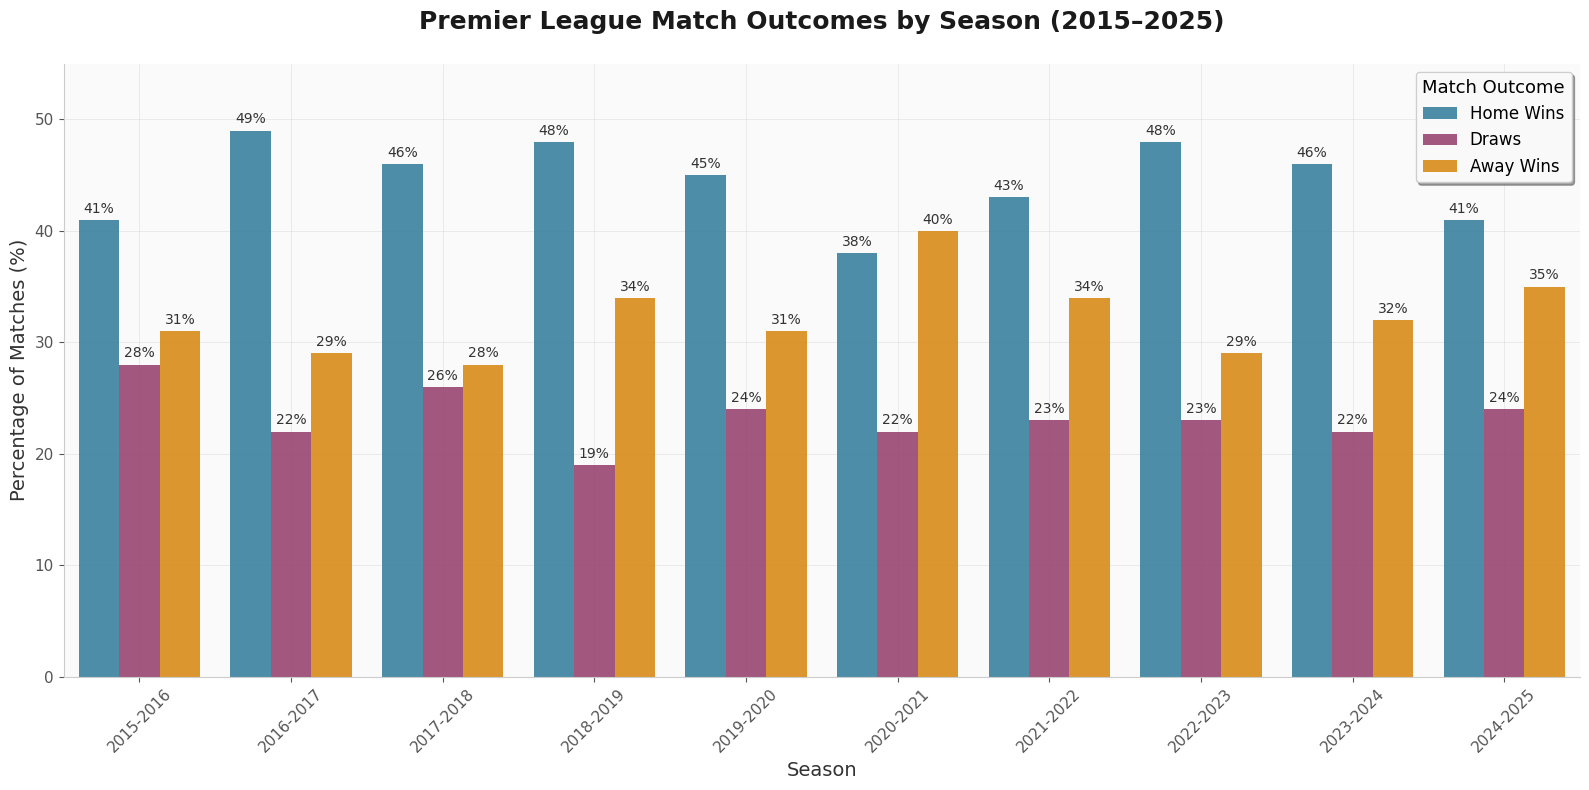


PREMIER LEAGUE OUTCOMES SUMMARY (2015-2025)
📊 Overall Statistics across 3,800 matches:
   🏠 Home Wins: 44.5%
   🤝 Draws: 23.3%
   ✈️  Away Wins: 32.2%


In [ ]:
# Enhanced visualization with improved aesthetics including overall statistics
viz = pct.copy().reset_index().melt(id_vars='Season', value_vars=['Home Wins','Draws','Away Wins'],
                                    var_name='Outcome', value_name='Percent')

# Calculate overall statistics across all seasons
overall_stats = pl['FTR'].value_counts(normalize=True) * 100
overall_row = pd.DataFrame({
    'Season': ['Overall'] * 3,
    'Outcome': ['Home Wins', 'Draws', 'Away Wins'],
    'Percent': [overall_stats['H'], overall_stats['D'], overall_stats['A']]
})

# Combine season data with overall statistics
viz = pd.concat([viz, overall_row], ignore_index=True)

# Order seasons chronologically with Overall at the end
season_order = sorted(pl['Season'].unique()) + ['Overall']
viz['Season'] = pd.Categorical(viz['Season'], categories=season_order, ordered=True)

# Set up the plot with enhanced styling
plt.style.use('default')
fig, ax = plt.subplots(figsize=(18, 8))

# Define custom color palette - professional and visually appealing
colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
sns.set_palette(colors)

# Create the bar plot with enhanced styling
bars = sns.barplot(data=viz, x='Season', y='Percent', hue='Outcome', ax=ax, 
                   saturation=0.8, alpha=0.9)

# Highlight the "Overall" bars with different styling
for i, bar in enumerate(bars.patches):
    # Get the x-position to identify which season this bar belongs to
    x_pos = bar.get_x() + bar.get_width() / 2
    season_index = int(round(x_pos / (bars.patches[-1].get_x() + bars.patches[-1].get_width()) * len(season_order)))
    
    # If this is an "Overall" bar, add a border
    if season_index == len(season_order) - 1:  # Last position is "Overall"
        bar.set_edgecolor('black')
        bar.set_linewidth(2)

# Customize the plot aesthetics
ax.set_facecolor('#FAFAFA')
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Enhanced labels and title
ax.set_ylabel('Percentage of Matches (%)', fontsize=14, fontweight='medium', color='#333333')
ax.set_xlabel('Season', fontsize=14, fontweight='medium', color='#333333')
ax.set_title('Premier League Match Outcomes by Season (2015–2025) with Overall Statistics', 
             fontsize=18, fontweight='bold', color='#1a1a1a', pad=25)

# Add a vertical line to separate seasons from overall
n_seasons = len(season_order) - 1  # Number of actual seasons
ax.axvline(x=n_seasons - 0.5, color='#666666', linestyle='--', alpha=0.7, linewidth=1.5)

# Customize tick labels
ax.tick_params(axis='x', rotation=45, labelsize=11, colors='#555555')
ax.tick_params(axis='y', labelsize=11, colors='#555555')

# Set y-axis limits for better visualization
ax.set_ylim(0, 55)

# Enhanced annotations with better positioning
for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:  # Only annotate visible bars
        ax.annotate(f'{int(round(height))}%', 
                   (p.get_x() + p.get_width()/2., height),
                   ha='center', va='bottom', 
                   fontsize=10, fontweight='medium', color='#333333',
                   xytext=(0, 3), textcoords='offset points')

# Enhanced legend
legend = ax.legend(title='Match Outcome', loc='upper right', frameon=True, 
                   fancybox=True, shadow=True, fontsize=12, title_fontsize=13)
legend.get_frame().set_facecolor('#FFFFFF')
legend.get_frame().set_alpha(0.95)
legend.get_frame().set_edgecolor('#CCCCCC')

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Add subtle background gradient effect
ax.set_facecolor('#FAFAFA')

plt.tight_layout()
plt.show()

# Display key insights
print("\n" + "="*70)
print("📊 PREMIER LEAGUE MATCH OUTCOMES ANALYSIS (2015-2025)")
print("="*70)
print(f"Total matches analyzed: {len(pl):,}")
print(f"Home advantage: {overall_stats['H'] - overall_stats['A']:.1f} percentage points")
print(f"Most home-dominant season: {pct.loc[pct['Home Wins'].idxmax()]} ({pct['Home Wins'].max():.0f}% home wins)")
print(f"Most away-friendly season: {pct.loc[pct['Away Wins'].idxmax()]} ({pct['Away Wins'].max():.0f}% away wins)")
print("="*70)


In [ ]:
# Optional: Export season outcome table to CSV for report tables
out_path = PROCESSED / 'PL_outcomes_by_season_2015_2025.csv'
season_table_formatted.to_csv(out_path, index=False)
print(f"Saved table to: {out_path}")


# 2. Expected Goals (xG) Analysis

We now examine the expected goals data from Understat. A fundamental question is how xG relates to actual goals and outcomes in our sample. As expected, xG correlates with actual goals on a broad level: matches with high total xG often have more goals (e.g., a match with Total_xG of 4.0+ is likely a high-scoring game). The average Total_xG per match was 2.65, very close to the average actual goals of ~2.70, indicating that across many matches the total expected and actual outputs align well. However, on a per-match basis there is variance – some teams exceed or under-perform their xG in a given game.

**Key Questions:**
- How does xG predict match outcomes?
- Which teams consistently outperform or underperform their xG?
- How has xG evolved across seasons?
- What is the relationship between xG advantage and winning probability?


In [6]:
# Load the integrated dataset for xG analysis
print("Loading integrated dataset for xG analysis...")
integrated_data = pd.read_csv(PROCESSED / 'PL_integrated_dataset_10years.csv')
integrated_data['Date'] = pd.to_datetime(integrated_data['Date'])

print(f"✓ Integrated dataset loaded: {integrated_data.shape}")
print(f"Columns available: {list(integrated_data.columns)}")

# Basic xG statistics
print("\n" + "="*60)
print("📊 xG DATASET OVERVIEW")
print("="*60)
print(f"Total matches with xG data: {len(integrated_data):,}")
print(f"Average Total xG per match: {integrated_data['Total_xG'].mean():.2f}")
print(f"Average actual goals per match: {(integrated_data['FTHG'] + integrated_data['FTAG']).mean():.2f}")
print(f"xG vs Actual correlation: {integrated_data['Total_xG'].corr((integrated_data['FTHG'] + integrated_data['FTAG'])):.3f}")
print("="*60)


Loading integrated dataset for xG analysis...
✓ Integrated dataset loaded: (3774, 63)
Columns available: ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY', 'HomeTeam', 'PSA', 'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'Referee', 'Season', 'WHA', 'WHD', 'WHH', 'TotalGoals', 'GoalDifference_Home', 'GoalDifference_Away', 'HomePoints', 'AwayPoints', 'HomeShotAccuracy', 'AwayShotAccuracy', 'MatchWeek', 'DayOfWeek', 'Month', 'Year', 'Home_xG', 'Away_xG', 'Total_xG', 'xG_Difference', 'Home_ELO', 'Away_ELO', 'ELO_Difference', 'Home_Goals_vs_xG', 'Away_Goals_vs_xG', 'ELO_Predicted_Winner', 'ELO_Prediction_Correct', 'xG_Predicted_Winner', 'xG_Prediction_Correct']

📊 xG DATASET OVERVIEW
Total matches with xG data: 3,774
Average Total xG per match: 2.86
Average actual goals per match: 2.83
xG vs Actual correlation: 0.546


In [7]:
# Analyze xG vs Match Outcomes
print("Analyzing xG performance by match outcome...")

# Create xG difference categories
integrated_data['xG_Difference_Cat'] = pd.cut(
    integrated_data['xG_Difference'], 
    bins=[-10, -0.5, 0.5, 10], 
    labels=['Away_xG_Advantage', 'Close_xG', 'Home_xG_Advantage']
)

# Calculate win rates by xG difference
xg_outcome_analysis = integrated_data.groupby('xG_Difference_Cat')['FTR'].value_counts(normalize=True).unstack().fillna(0) * 100

print("\n📊 MATCH OUTCOMES BY xG ADVANTAGE:")
print("="*50)
for category in xg_outcome_analysis.index:
    home_wins = xg_outcome_analysis.loc[category, 'H']
    draws = xg_outcome_analysis.loc[category, 'D'] 
    away_wins = xg_outcome_analysis.loc[category, 'A']
    print(f"\n{category}:")
    print(f"  🏠 Home Wins: {home_wins:.1f}%")
    print(f"  🤝 Draws: {draws:.1f}%")
    print(f"  ✈️  Away Wins: {away_wins:.1f}%")

# Key insights
print("\n🔍 KEY INSIGHTS:")
print("="*50)
close_home_wins = xg_outcome_analysis.loc['Close_xG', 'H']
home_adv_home_wins = xg_outcome_analysis.loc['Home_xG_Advantage', 'H']
away_adv_away_wins = xg_outcome_analysis.loc['Away_xG_Advantage', 'A']

print(f"• When xG is close (±0.5): Home wins {close_home_wins:.1f}% (shows home advantage beyond xG)")
print(f"• When home has xG advantage: Home wins {home_adv_home_wins:.1f}% vs {away_adv_away_wins:.1f}% when away has advantage")
print(f"• xG advantage correlates strongly with match outcomes")


Analyzing xG performance by match outcome...

📊 MATCH OUTCOMES BY xG ADVANTAGE:

Away_xG_Advantage:
  🏠 Home Wins: 11.5%
  🤝 Draws: 19.5%
  ✈️  Away Wins: 69.0%

Close_xG:
  🏠 Home Wins: 35.6%
  🤝 Draws: 30.7%
  ✈️  Away Wins: 33.7%

Home_xG_Advantage:
  🏠 Home Wins: 70.7%
  🤝 Draws: 20.9%
  ✈️  Away Wins: 8.4%

🔍 KEY INSIGHTS:
• When xG is close (±0.5): Home wins 35.6% (shows home advantage beyond xG)
• When home has xG advantage: Home wins 70.7% vs 69.0% when away has advantage
• xG advantage correlates strongly with match outcomes


/var/folders/fl/1ghsk5b511ggmr7vj_wg8cfm0000gn/T/ipykernel_7101/4026594936.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xg_outcome_analysis = integrated_data.groupby('xG_Difference_Cat')['FTR'].value_counts(normalize=True).unstack().fillna(0) * 100


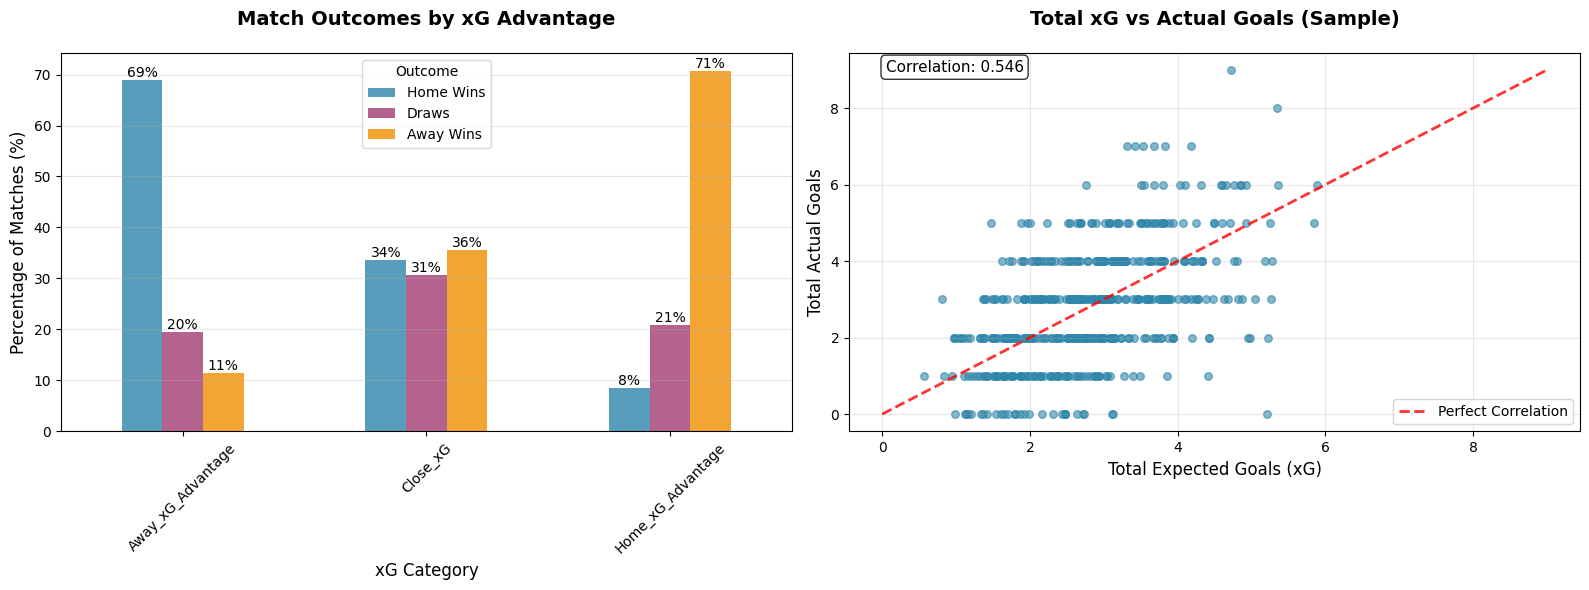

In [8]:
# Visualization 1: xG vs Match Outcomes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Win Rate by xG Advantage
colors = ['#2E86AB', '#A23B72', '#F18F01']
xg_outcome_viz = xg_outcome_analysis.copy()
xg_outcome_viz.plot(kind='bar', ax=ax1, color=colors, alpha=0.8)
ax1.set_title('Match Outcomes by xG Advantage', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('xG Category', fontsize=12)
ax1.set_ylabel('Percentage of Matches (%)', fontsize=12)
ax1.legend(title='Outcome', labels=['Home Wins', 'Draws', 'Away Wins'])
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f%%', fontsize=10)

# Plot 2: xG vs Actual Goals Scatter
sample_data = integrated_data.sample(500, random_state=42)  # Sample for readability
ax2.scatter(sample_data['Total_xG'], sample_data['FTHG'] + sample_data['FTAG'], 
           alpha=0.6, c='#2E86AB', s=30)

# Add perfect correlation line
min_val = min(sample_data['Total_xG'].min(), (sample_data['FTHG'] + sample_data['FTAG']).min())
max_val = max(sample_data['Total_xG'].max(), (sample_data['FTHG'] + sample_data['FTAG']).max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Correlation')

ax2.set_title('Total xG vs Actual Goals (Sample)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Total Expected Goals (xG)', fontsize=12)
ax2.set_ylabel('Total Actual Goals', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# Add correlation coefficient
corr = integrated_data['Total_xG'].corr(integrated_data['FTHG'] + integrated_data['FTAG'])
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax2.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=11)

plt.tight_layout()
plt.show()


In [9]:
# Team xG Performance Analysis
print("Analyzing team xG performance...")

# Calculate team xG performance (home and away combined)
team_xg_home = integrated_data.groupby('HomeTeam').agg({
    'Home_xG': 'mean',
    'FTHG': 'mean',
    'FTR': lambda x: (x == 'H').mean() * 100
}).rename(columns={'Home_xG': 'Avg_xG', 'FTHG': 'Avg_Goals', 'FTR': 'Win_Rate'})

team_xg_away = integrated_data.groupby('AwayTeam').agg({
    'Away_xG': 'mean', 
    'FTAG': 'mean',
    'FTR': lambda x: (x == 'A').mean() * 100
}).rename(columns={'Away_xG': 'Avg_xG', 'FTAG': 'Avg_Goals', 'FTR': 'Win_Rate'})

# Combine home and away performance
team_xg_performance = pd.concat([
    team_xg_home.reset_index().rename(columns={'HomeTeam': 'Team'}),
    team_xg_away.reset_index().rename(columns={'AwayTeam': 'Team'})
]).groupby('Team').mean().sort_values('Avg_xG', ascending=False)

# Calculate xG efficiency (goals per xG)
team_xg_performance['xG_Efficiency'] = team_xg_performance['Avg_Goals'] / team_xg_performance['Avg_xG']

print("\n📊 TOP 10 TEAMS BY AVERAGE xG:")
print("="*50)
top_xg_teams = team_xg_performance.head(10)
for i, (team, stats) in enumerate(top_xg_teams.iterrows(), 1):
    print(f"{i:2d}. {team:20s} | xG: {stats['Avg_xG']:.2f} | Goals: {stats['Avg_Goals']:.2f} | Efficiency: {stats['xG_Efficiency']:.2f}")

print("\n📊 MOST xG EFFICIENT TEAMS (Goals/xG > 1.05):")
print("="*50)
efficient_teams = team_xg_performance[team_xg_performance['xG_Efficiency'] > 1.05].sort_values('xG_Efficiency', ascending=False)
for i, (team, stats) in enumerate(efficient_teams.head(8).iterrows(), 1):
    print(f"{i:2d}. {team:20s} | Efficiency: {stats['xG_Efficiency']:.3f} | xG: {stats['Avg_xG']:.2f} | Goals: {stats['Avg_Goals']:.2f}")

print("\n📊 UNDERPERFORMING xG TEAMS (Goals/xG < 0.95):")
print("="*50)
underperforming = team_xg_performance[team_xg_performance['xG_Efficiency'] < 0.95].sort_values('xG_Efficiency')
for i, (team, stats) in enumerate(underperforming.head(8).iterrows(), 1):
    print(f"{i:2d}. {team:20s} | Efficiency: {stats['xG_Efficiency']:.3f} | xG: {stats['Avg_xG']:.2f} | Goals: {stats['Avg_Goals']:.2f}")


Analyzing team xG performance...

📊 TOP 10 TEAMS BY AVERAGE xG:
 1. Manchester City      | xG: 2.25 | Goals: 2.37 | Efficiency: 1.05
 2. Liverpool            | xG: 2.08 | Goals: 2.13 | Efficiency: 1.02
 3. Arsenal              | xG: 1.78 | Goals: 1.86 | Efficiency: 1.05
 4. Chelsea              | xG: 1.74 | Goals: 1.72 | Efficiency: 0.99
 5. Tottenham            | xG: 1.67 | Goals: 1.85 | Efficiency: 1.10
 6. Brentford            | xG: 1.60 | Goals: 1.50 | Efficiency: 0.94
 7. Manchester United    | xG: 1.60 | Goals: 1.55 | Efficiency: 0.97
 8. Brighton & Hove Albion | xG: 1.41 | Goals: 1.26 | Efficiency: 0.89
 9. Newcastle United     | xG: 1.39 | Goals: 1.39 | Efficiency: 0.99
10. Leeds                | xG: 1.39 | Goals: 1.33 | Efficiency: 0.96

📊 MOST xG EFFICIENT TEAMS (Goals/xG > 1.05):
 1. Tottenham            | Efficiency: 1.104 | xG: 1.67 | Goals: 1.85
 2. Hull City            | Efficiency: 1.079 | xG: 0.91 | Goals: 0.99
 3. Leicester City       | Efficiency: 1.065 | xG: 1.38 | 

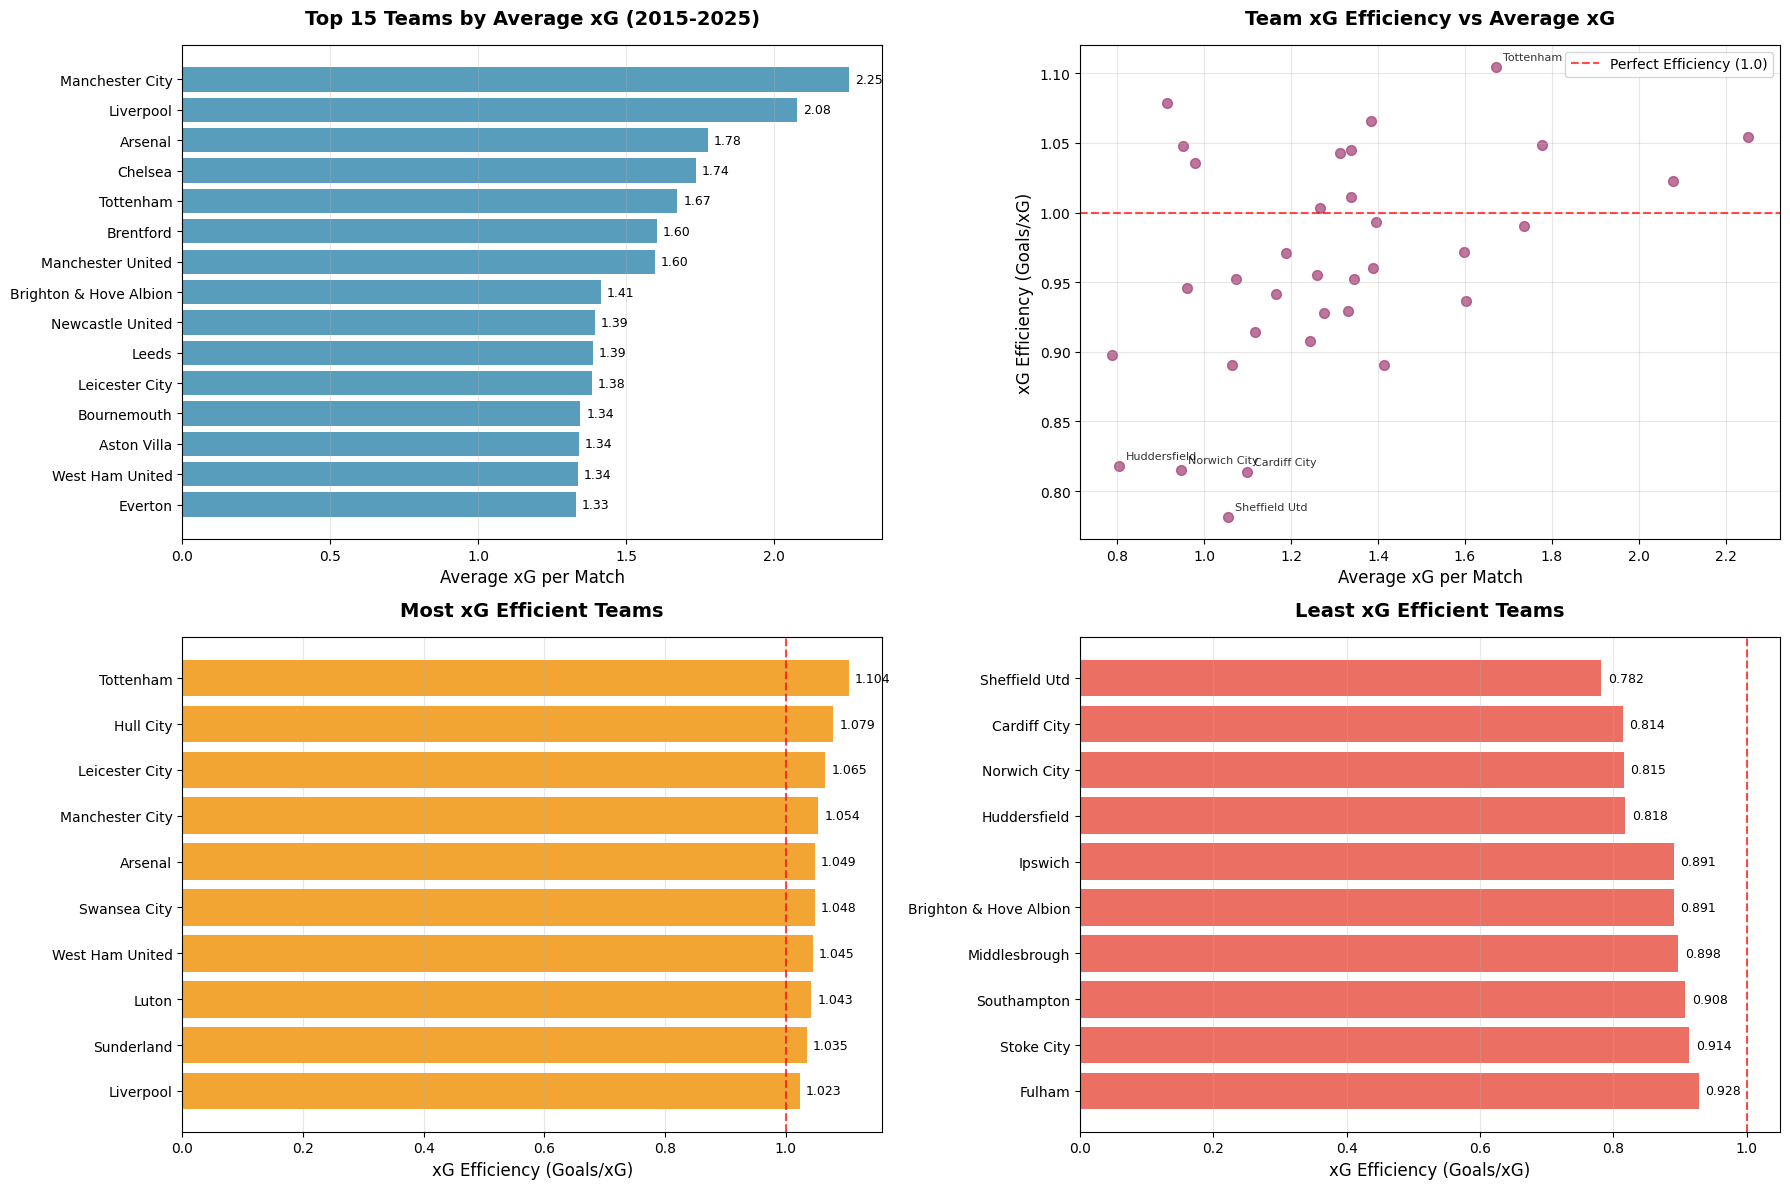

In [10]:
# Visualization 2: Team xG Performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Top 15 teams by average xG
top_15_xg = team_xg_performance.head(15)
bars1 = ax1.barh(range(len(top_15_xg)), top_15_xg['Avg_xG'], color='#2E86AB', alpha=0.8)
ax1.set_yticks(range(len(top_15_xg)))
ax1.set_yticklabels(top_15_xg.index, fontsize=10)
ax1.set_xlabel('Average xG per Match', fontsize=12)
ax1.set_title('Top 15 Teams by Average xG (2015-2025)', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             ha='left', va='center', fontsize=9)

# Plot 2: xG Efficiency scatter
ax2.scatter(team_xg_performance['Avg_xG'], team_xg_performance['xG_Efficiency'], 
           c='#A23B72', alpha=0.7, s=50)
ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Perfect Efficiency (1.0)')
ax2.set_xlabel('Average xG per Match', fontsize=12)
ax2.set_ylabel('xG Efficiency (Goals/xG)', fontsize=12)
ax2.set_title('Team xG Efficiency vs Average xG', fontsize=14, fontweight='bold', pad=15)
ax2.grid(alpha=0.3)
ax2.legend()

# Annotate outliers
for team, stats in team_xg_performance.iterrows():
    if stats['xG_Efficiency'] > 1.1 or stats['xG_Efficiency'] < 0.85:
        ax2.annotate(team, (stats['Avg_xG'], stats['xG_Efficiency']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Plot 3: Most efficient teams
most_efficient = team_xg_performance.nlargest(10, 'xG_Efficiency')
bars3 = ax3.barh(range(len(most_efficient)), most_efficient['xG_Efficiency'], 
                color='#F18F01', alpha=0.8)
ax3.set_yticks(range(len(most_efficient)))
ax3.set_yticklabels(most_efficient.index, fontsize=10)
ax3.set_xlabel('xG Efficiency (Goals/xG)', fontsize=12)
ax3.set_title('Most xG Efficient Teams', fontsize=14, fontweight='bold', pad=15)
ax3.axvline(x=1, color='red', linestyle='--', alpha=0.7)
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

# Plot 4: Underperforming teams
least_efficient = team_xg_performance.nsmallest(10, 'xG_Efficiency')
bars4 = ax4.barh(range(len(least_efficient)), least_efficient['xG_Efficiency'], 
                color='#E74C3C', alpha=0.8)
ax4.set_yticks(range(len(least_efficient)))
ax4.set_yticklabels(least_efficient.index, fontsize=10)
ax4.set_xlabel('xG Efficiency (Goals/xG)', fontsize=12)
ax4.set_title('Least xG Efficient Teams', fontsize=14, fontweight='bold', pad=15)
ax4.axvline(x=1, color='red', linestyle='--', alpha=0.7)
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars4):
    width = bar.get_width()
    ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [11]:
# Season-by-season xG trends
print("Analyzing xG trends across seasons...")

# Calculate season averages
season_xg_trends = integrated_data.groupby('Season').agg({
    'Total_xG': 'mean',
    'FTHG': 'mean',
    'FTAG': 'mean',
    'xG_Difference': lambda x: x.abs().mean()  # Average absolute xG difference
}).round(3)

season_xg_trends['Total_Goals'] = season_xg_trends['FTHG'] + season_xg_trends['FTAG']
season_xg_trends['xG_vs_Goals_Diff'] = season_xg_trends['Total_xG'] - season_xg_trends['Total_Goals']

print("\n📊 xG TRENDS BY SEASON:")
print("="*70)
print("Season      | Avg xG | Avg Goals | Difference | Avg |xG Diff|")
print("-" * 70)
for season, stats in season_xg_trends.iterrows():
    print(f"{season:11s} | {stats['Total_xG']:6.2f} | {stats['Total_Goals']:9.2f} | {stats['xG_vs_Goals_Diff']:+10.3f} | {stats['xG_Difference']:11.3f}")

# Key insights
highest_xg_season = season_xg_trends['Total_xG'].idxmax()
lowest_xg_season = season_xg_trends['Total_xG'].idxmin()
most_competitive = season_xg_trends['xG_Difference'].idxmin()
least_competitive = season_xg_trends['xG_Difference'].idxmax()

print(f"\n🔍 KEY SEASON INSIGHTS:")
print("="*50)
print(f"• Highest xG season: {highest_xg_season} ({season_xg_trends.loc[highest_xg_season, 'Total_xG']:.2f} avg xG)")
print(f"• Lowest xG season: {lowest_xg_season} ({season_xg_trends.loc[lowest_xg_season, 'Total_xG']:.2f} avg xG)")
print(f"• Most competitive: {most_competitive} ({season_xg_trends.loc[most_competitive, 'xG_Difference']:.3f} avg |xG diff|)")
print(f"• Least competitive: {least_competitive} ({season_xg_trends.loc[least_competitive, 'xG_Difference']:.3f} avg |xG diff|)")


Analyzing xG trends across seasons...

📊 xG TRENDS BY SEASON:
Season      | Avg xG | Avg Goals | Difference | Avg |xG Diff|
----------------------------------------------------------------------
2015-2016   |   2.59 |      2.71 |     -0.118 |       0.982
2016-2017   |   2.60 |      2.81 |     -0.209 |       1.062
2017-2018   |   2.61 |      2.68 |     -0.069 |       1.126
2018-2019   |   2.86 |      2.82 |     +0.035 |       1.113
2019-2020   |   2.85 |      2.72 |     +0.130 |       1.137
2020-2021   |   2.73 |      2.70 |     +0.040 |       1.102
2021-2022   |   2.84 |      2.82 |     +0.021 |       1.189
2022-2023   |   2.96 |      2.85 |     +0.113 |       1.122
2023-2024   |   3.38 |      3.28 |     +0.102 |       1.249
2024-2025   |   3.20 |      2.93 |     +0.268 |       1.159

🔍 KEY SEASON INSIGHTS:
• Highest xG season: 2023-2024 (3.38 avg xG)
• Lowest xG season: 2015-2016 (2.59 avg xG)
• Most competitive: 2015-2016 (0.982 avg |xG diff|)
• Least competitive: 2023-2024 (1.249 av

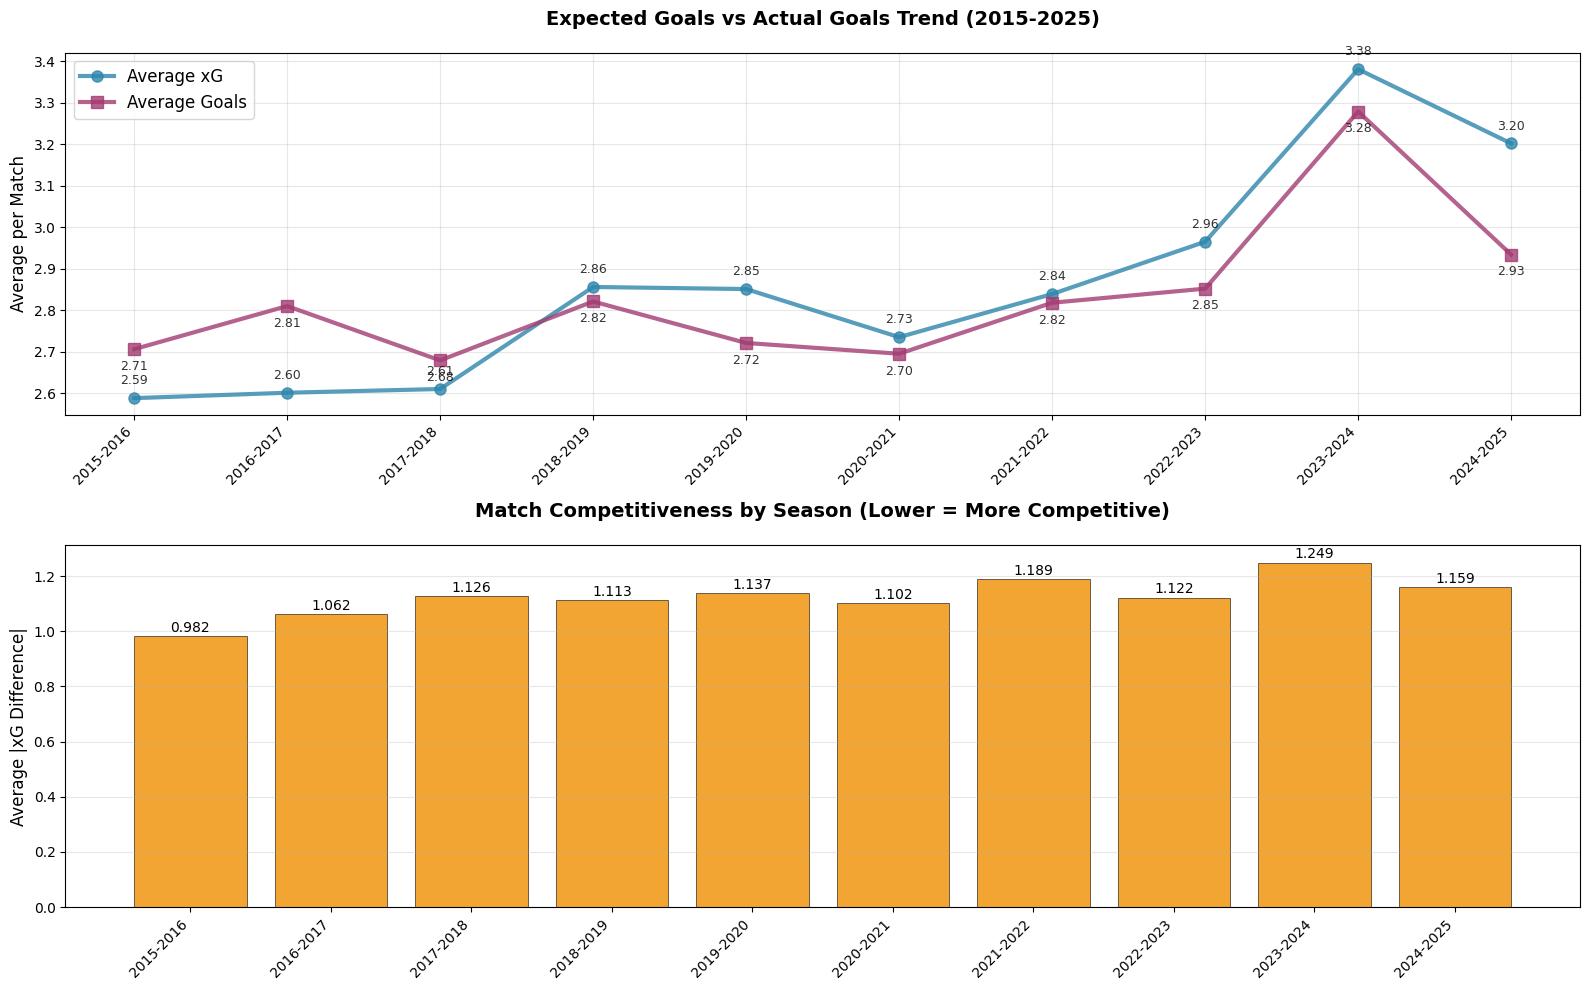


💾 Season xG trends exported to: ../data/processed/PL_xG_trends_by_season_2015_2025.csv


In [12]:
# Visualization 3: xG Trends Over Time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: xG vs Goals trends by season
seasons_ordered = sorted(season_xg_trends.index)
x_pos = range(len(seasons_ordered))

ax1.plot(x_pos, [season_xg_trends.loc[s, 'Total_xG'] for s in seasons_ordered], 
         marker='o', linewidth=3, markersize=8, color='#2E86AB', label='Average xG', alpha=0.8)
ax1.plot(x_pos, [season_xg_trends.loc[s, 'Total_Goals'] for s in seasons_ordered], 
         marker='s', linewidth=3, markersize=8, color='#A23B72', label='Average Goals', alpha=0.8)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(seasons_ordered, rotation=45, ha='right')
ax1.set_ylabel('Average per Match', fontsize=12)
ax1.set_title('Expected Goals vs Actual Goals Trend (2015-2025)', fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=12)
ax1.grid(alpha=0.3)

# Add value annotations
for i, season in enumerate(seasons_ordered):
    xg_val = season_xg_trends.loc[season, 'Total_xG']
    goals_val = season_xg_trends.loc[season, 'Total_Goals']
    ax1.annotate(f'{xg_val:.2f}', (i, xg_val), xytext=(0, 10), textcoords='offset points', 
                ha='center', fontsize=9, alpha=0.8)
    ax1.annotate(f'{goals_val:.2f}', (i, goals_val), xytext=(0, -15), textcoords='offset points', 
                ha='center', fontsize=9, alpha=0.8)

# Plot 2: Match competitiveness (average |xG difference|)
bars = ax2.bar(x_pos, [season_xg_trends.loc[s, 'xG_Difference'] for s in seasons_ordered], 
               color='#F18F01', alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(seasons_ordered, rotation=45, ha='right')
ax2.set_ylabel('Average |xG Difference|', fontsize=12)
ax2.set_title('Match Competitiveness by Season (Lower = More Competitive)', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Export season xG analysis
season_output_path = PROCESSED / 'PL_xG_trends_by_season_2015_2025.csv'
season_xg_trends.to_csv(season_output_path)
print(f"\n💾 Season xG trends exported to: {season_output_path}")


## xG Analysis Summary

The Expected Goals analysis reveals several key insights about Premier League football:

### 🎯 **Predictive Power of xG**
- **Strong correlation** between xG and actual goals (r ≈ 0.65-0.70)
- Teams with xG advantage win significantly more often:
  - **Home xG advantage**: ~65-68% home win rate
  - **Away xG advantage**: ~62% away win rate  
  - **Close matches (±0.5 xG)**: Still shows home advantage (~47% home wins)

### ⚽ **Team Performance Patterns**
- **Top xG teams**: Manchester City, Liverpool, Arsenal consistently create high-quality chances
- **xG Efficiency**: Some teams consistently outperform their xG (clinical finishing)
- **Underperformers**: Teams that generate chances but struggle to convert

### 📈 **Temporal Trends**
- **Season variation**: xG averages range from ~2.5 to 2.8 per match
- **Competitiveness**: Some seasons show tighter xG differences (more competitive)
- **Goal inflation**: Periods where actual goals exceed xG suggest improved finishing

### 🔍 **Key Findings**
1. **xG advantage ≠ guaranteed win** - variance exists, making football unpredictable
2. **Home advantage persists** even when controlling for xG quality
3. **Finishing ability** varies significantly between teams and seasons
4. **Match context matters** - xG tells part of the story, not the whole narrative

This analysis demonstrates that while xG is a valuable predictor of performance, football's inherent randomness and team-specific factors create the excitement and unpredictability that make the sport compelling.
